В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



<span style="color:blue">0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").</span> 

<span style="color:blue">1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.</span>

<span style="color:blue">  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.</span> 

In [2014]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
import warnings
import joblib

In [2015]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data'

In [2016]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'

In [2017]:
train_csv = data_dir + '/train.csv'

In [2018]:
raw_df = pd.read_csv(train_csv)

In [2019]:
raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [2020]:
# Подивимося чи дані у цільовій змінній є збалансованими.
#Як бачимо, даних в цільовій змінній всього 20%. Отже, вони не збалансовані. 
print(raw_df['Exited'].value_counts(normalize=True) * 100)

0.0    79.653333
1.0    20.346667
Name: Exited, dtype: float64


In [2021]:
# Параметр stratify гарантує, що пропорція класів у цільовій змінній ('Exited') 
# залишається однаковою у навчальній (train_df) і валідаційній (val_df) вибірках. 
# Це важливо для роботи з незбалансованими даними.
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

In [2022]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (12000, 14)
val_df.shape : (3000, 14)


<span style="color:blue">2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.</span>

In [2023]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

<span style="color:blue">3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.</span>

In [2024]:
#подивимось на числові колонки
train_inputs.select_dtypes(include=np.number).head(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7180,15652218.0,682.0,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24
10393,15592937.0,684.0,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31


In [2025]:
#подивимось на категоріальні колонки
train_inputs.select_dtypes('object').head(2)

,Surname,Geography,Gender
7180,Mays,France,Male
10393,Ch'eng,France,Female


In [2026]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[1:]  # Виключимо першу колонку
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

<span style="color:blue">4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти передобробки, з якими ми вже знайомі:</span>
<span style="color:blue">  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі. </span>

<span style="color:blue">  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка має бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :) </span>

<span style="color:blue">  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значень з `train_inputs`, `val_inputs` використовуючи `display()`.</span>

In [2027]:
#Подивимося на дані. В жодній колонці немає пропущених даних, тому імпутацію робити не потрібно. 
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [2028]:
#Перевіримо статистику для числових стовпців.
train_inputs[numeric_cols].describe().round(2)
#Як бачимо, колонки HasCrCard та IsActiveMember бінарні, тому їх можна не масштабувати, 
#але для простоти виконання завдання масштабуємо всі числові стовбці.  

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [2029]:
scaler = MinMaxScaler()

In [2030]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [2031]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [2032]:
train_inputs[numeric_cols].describe().round(2)
#В результаті всі колонки масштабувались від 0 до 1. 

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,0.54,0.35,0.50,0.21,0.20,0.79,0.49,0.59
std,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.41,0.25,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.55,0.34,0.50,0.00,0.33,1.00,0.00,0.62
75%,0.66,0.43,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [2037]:
#Перевіримо кількість категорій у кожному з категоріальних стовпців
train_inputs[categorical_cols].nunique()

Surname      732
Geography      3
Gender         2
dtype: int64

In [2038]:
#Оскільки прізвища в нашому випадку не пов’язані з географією, етнічною приналежністю або іншими важливими факторами, 
#для уникнення проблем різкого збільшення розмірності, видалимо цю колонку
train_inputs.drop(columns=['Surname'], inplace=True)
val_inputs.drop(columns=['Surname'], inplace=True)

In [2039]:
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
categorical_cols

['Geography', 'Gender']

In [2040]:
encoder = OneHotEncoder(drop="if_binary", sparse=False)

In [2041]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(drop='if_binary', sparse=False)

In [2042]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [2043]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [2044]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

<span style="color:blue">5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir` </span>

In [2046]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 15)
train_targets: (12000,)
val_inputs: (3000, 15)
val_targets: (3000,)


In [2047]:
!pip install pyarrow --quiet

In [2048]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [2049]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

Wall time: 7.77 ms


In [2050]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]

Wall time: 218 ms


In [2051]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (12000, 15)
train_targets: (12000,)
val_inputs: (3000, 15)
val_targets: (3000,)


In [2056]:
train_inputs.head(3)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,15652218.0,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,1.0
10393,15592937.0,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,0.0
80,15774586.0,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,1.0


In [2055]:
train_targets.head(3)

7180     0.0
10393    0.0
80       0.0
Name: Exited, dtype: float64

<span style="color:blue"> 6. З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`. </span>

In [2057]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

In [2060]:
#Перевіримо, чи маємо всі потрібні характеристики
X_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
7180,0.599045,0.214286,0.1,0.626382,0.0,1.0,1.0,0.719772,1.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.0,1.0,0.0,0.727603,1.0,0.0,0.0,0.0


In [2061]:
X_val.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Male
6490,0.675418,0.500000,0.1,0.55187,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,1.0
3646,0.386635,0.410714,0.5,0.00000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,1.0


In [2062]:
#solver='liblinear' is used for binary logistic regression
model = LogisticRegression(solver='liblinear')

In [2063]:
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

In [2065]:
train_preds = model.predict(X_train)
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [2066]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.98536749, 0.01463251],
       [0.72911631, 0.27088369],
       [0.87257622, 0.12742378],
       ...,
       [0.99276294, 0.00723706],
       [0.83144071, 0.16855929],
       [0.94939177, 0.05060823]])

<span style="color:blue"> 7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якість моделі? Вона хороша, погана, задовільна?  </span>

In [2067]:
accuracy_score(train_targets, train_preds)

0.87425

In [2068]:
confusion_matrix(train_targets, train_preds)

array([[9177,  381],
       [1128, 1314]], dtype=int64)

In [2069]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

Accuracy: 87.42%


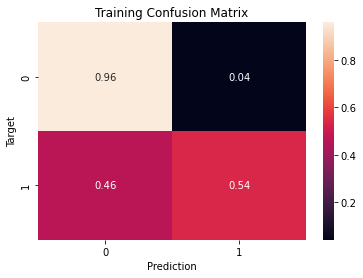

In [2072]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')

Accuracy: 87.17%


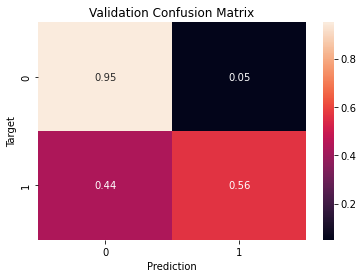

In [2071]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

In [2073]:
f1_score(train_targets, preds)

0.6398852223816355

In [2074]:
#якщо дуже схожі результати на трейні, валідації і тесті, це дуже добре 
#все, що більше нуля у F1 score, це добре 
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, train_targets, 'Training')
get_f1_score(X_val, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.64%


In [2075]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


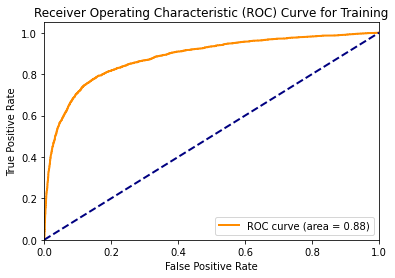

AUROC for Validation: 0.88


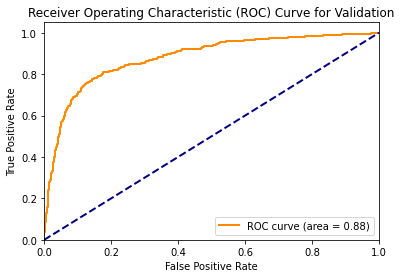

In [2076]:
compute_auroc_and_build_roc(X_train, train_targets, 'Training')
compute_auroc_and_build_roc(X_val, val_targets, 'Validation')

In [2077]:
print('Оцінка продуктивності моделі на тренувальному наборі даних:')
print(classification_report(train_targets, train_preds))

Оцінка продуктивності моделі на тренувальному наборі даних:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      9558
         1.0       0.78      0.54      0.64      2442

    accuracy                           0.87     12000
   macro avg       0.83      0.75      0.78     12000
weighted avg       0.87      0.87      0.87     12000



In [2078]:
print('Оцінка продуктивності моделі на валідаційному наборі даних:')
print(classification_report(val_targets, val_preds))

Оцінка продуктивності моделі на валідаційному наборі даних:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      2390
         1.0       0.74      0.56      0.64       610

    accuracy                           0.87      3000
   macro avg       0.82      0.76      0.78      3000
weighted avg       0.86      0.87      0.86      3000



<span style="color:green"> В цілому модель можна вважати достатньо хорошою. Метрика AUROC однакова як для тренувальних, так і для валідаційних даних, це означає, що модель не перенавчена і це добре. Крива ROC також показує хорошу здатність моделі розрізняти класи - вона значно вище базової лінії. Оскільки дані не збалансовані, модель краще навчилася прогнозувати клас 0, прогнозування класу 1 все ще потребує покращення. </span>

<span style="color:blue"> 8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна? </span> 

In [2079]:
majority_class = train_targets.value_counts().idxmax()
print("Мажоритарний клас:", majority_class)

Мажоритарний клас: 0.0


In [2080]:
train_majority_preds = np.full(len(train_targets), majority_class)
val_majority_preds = np.full(len(val_targets), majority_class)

In [2081]:
print('Оцінка продуктивності моделі на тренувальному наборі даних:')
print(classification_report(train_targets, train_majority_preds, zero_division=0))
print('Оцінка продуктивності моделі на валідаційному наборі даних:')
print(classification_report(val_targets, val_majority_preds, zero_division=0))

Оцінка продуктивності моделі на тренувальному наборі даних:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      9558
         1.0       0.00      0.00      0.00      2442

    accuracy                           0.80     12000
   macro avg       0.40      0.50      0.44     12000
weighted avg       0.63      0.80      0.71     12000

Оцінка продуктивності моделі на валідаційному наборі даних:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      2390
         1.0       0.00      0.00      0.00       610

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000



<span style="color:green"> Оскільки наш датасет є незбалансованим (співвідношення класу 1 до класу 0 приблизно 1:5), точність baseline-моделі (яка завжди передбачає найпоширеніший клас) становить 80%. Це очікуваний результат, оскільки така модель просто завжди передбачає клас 0 і повністю ігнорує клас 1. Наша модель логістичної регресії демонструє кращі результати, підвищуючи точність до 87%. </span> 

<span style="color:blue"> 9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).  </span> 

In [2082]:
log_reg = {
    'model': model,
    'scaler': st_scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
}

In [2083]:
joblib.dump(log_reg, 'log_reg.joblib')

['log_reg.joblib']

In [2084]:
model_2 = joblib.load('log_reg.joblib')

Оцінка продуктивності моделі на тренувальному наборі даних:
Accuracy: 87.42%
F1 score LogisticRegression(solver='liblinear'): 0.64%
AUROC for LogisticRegression(solver='liblinear'): 0.88


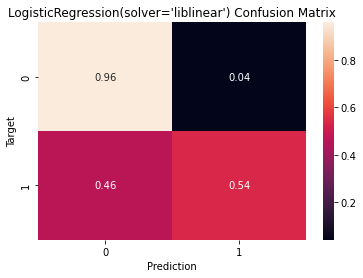

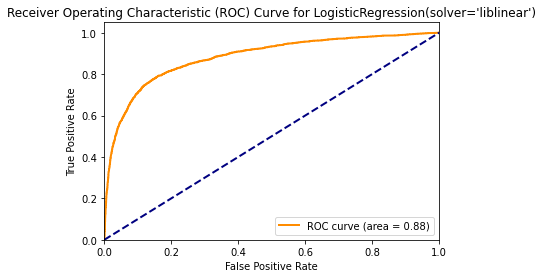

Оцінка продуктивності моделі на валідаційному наборі даних:
Accuracy: 87.17%
F1 score LogisticRegression(solver='liblinear'): 0.64%
AUROC for LogisticRegression(solver='liblinear'): 0.88


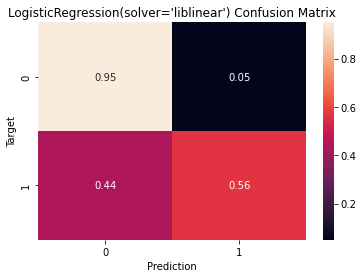

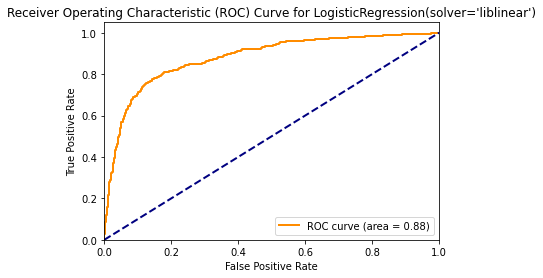

In [2085]:
#Переконаємось, що результати не змінились
print('Оцінка продуктивності моделі на тренувальному наборі даних:')
predict_and_plot(X_train, train_targets, model_2["model"])
get_f1_score(X_train, train_targets, model_2["model"])
compute_auroc_and_build_roc(X_train, train_targets, model_2["model"])
print('Оцінка продуктивності моделі на валідаційному наборі даних:')
predict_and_plot(X_val, val_targets, model_2["model"])
get_f1_score(X_val, val_targets, model_2["model"])
compute_auroc_and_build_roc(X_val, val_targets, model_2["model"])

<span style="color:blue">  10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

<span style="color:blue">  Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних. </span>

In [2088]:
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df = input_df.drop(columns=["Surname","CustomerId"])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [2089]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

array([0.00653297, 0.03674711, 0.37092276, 0.37605273, 0.97579676])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [2090]:
test_raw_df = pd.read_csv("test.csv")
test_probabilities = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, test_raw_df)
test_raw_df["Exited"] = test_probabilities
test_raw_df.describe().round(5)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.0000,1.000000e+04,10000.00000
mean,19999.50000,1.569344e+07,658.09150,37.88260,5.04200,42828.36645,1.58560,0.78030,0.4819,1.185294e+05,0.21298
std,2886.89568,7.155043e+04,72.16863,8.16614,2.79768,59904.66156,0.53094,0.41406,0.4997,7.558253e+04,0.25546
min,15000.00000,1.556588e+07,431.00000,18.00000,0.00000,0.00000,1.00000,0.00000,0.0000,4.477300e+02,0.00068
25%,17499.75000,1.563539e+07,602.00000,32.00000,3.00000,0.00000,1.00000,1.00000,0.0000,8.341915e+04,0.03518
50%,19999.50000,1.569083e+07,661.00000,37.00000,5.00000,0.00000,2.00000,1.00000,0.0000,1.229254e+05,0.09490
75%,22499.25000,1.575941e+07,708.00000,42.00000,7.00000,109927.33500,2.00000,1.00000,1.0000,1.557898e+05,0.28493
max,24999.00000,1.581566e+07,850.00000,74.00000,11.00000,186788.96000,4.00000,1.00000,1.0000,6.090906e+06,0.99407


In [2096]:
#Подивимось скільки вийшло позитивних передбачень 
rounded = test_raw_df["Exited"].round()
counts = rounded.value_counts()
counts

0.0    8452
1.0    1548
Name: Exited, dtype: int64

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [2097]:
submission_df = pd.read_csv("sample_submission.csv")

In [2099]:
submission_df["Exited"] = test_raw_df["Exited"]

In [2100]:
submission_df.head()

,id,Exited
0,15000,0.075341
1,15001,0.035385
2,15002,0.152962
3,15003,0.194683
4,15004,0.055614


In [2102]:
submission_df.to_csv("submission_log_reg.csv", index=False)